Importing libraries

In [5]:
import json
from collections import defaultdict, Counter
import ast
import time
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

import torch
# import torch_geometric as tg
from torch_geometric.data import Data
import torch.nn as nn
from torch_geometric.nn import GCNConv

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder

from sentence_transformers import SentenceTransformer

import re
import ast


Pandas setup

In [6]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 10)  # Limit number of rows displayed
pd.set_option('display.width', 1000)  # Set max width for table
pd.set_option('display.colheader_justify', 'center')  # Center-align column headers

Method for cleaning the data

In [7]:
def clean_special_chars(value):
    if isinstance(value, str):  
        return value.replace('\n', ' ').replace('\t', ' ').replace('\r', ' ').replace('  ', ' ').strip()
    return value 

Reading gab

In [8]:
content_gab = pd.read_csv('gab_reddit_benchmark/gab.csv')

content_gab["text"] = content_gab["text"].replace(to_replace=[None, np.nan, "", "nan", "n/a"], value="") 
content_gab["response"] = content_gab["response"].replace(to_replace=[None, np.nan, "", "nan", "n/a"], value="")
content_gab["hate_speech_idx"] = content_gab["hate_speech_idx"].replace(to_replace=[None, np.nan, "", "nan", "n/a"], value="") 

# content_gab["text"] = content_gab["text"].apply(clean_special_chars)
# content_gab["response"] = content_gab["response"].apply(clean_special_chars)

for index, row in content_gab.iterrows():
    row['text'] = row['text'].replace("'", '"')
    row['response'] = row['response'].replace("'", '"')

# content_gab = content_gab.applymap(clean_special_chars)
print(content_gab.head(n=10))
print('\n- - - - - -\n')
print(content_gab.columns)
print('\n- - - - - -\n')
print(content_gab.iloc[1]['id'])

                          id                                                text                        hate_speech_idx                      response                     
0                                    1. 39869714\r\n  1. i joined gab to remind myself how retarded ...         [1]      ["Using words that insult one group while defe...
1  1. 39845588\r\n2. \t39848775\r\n3. \t\t3991101...  1. This is what the left is really scared of. ...         [3]      ['You can disagree with someones opinion witho...
2                   1. 37485560\r\n2. \t37528625\r\n  1. It makes you an asshole.\r\n2. \tGive it to...         [2]      ['Your argument is more rational if you leave ...
3                   1. 39787626\r\n2. \t39794481\r\n  1. So they manage to provide a whole lot of da...         [2]      ["You shouldn't generalize a specific group or...
4  1. 37957930\r\n2. \t39953348\r\n3. \t\t3996521...  1. Hi there, i,m Keith, i hope you are doing w...         [3]      ['If someone is rude it 

Merge posts

In [9]:

def get_first_number(input_string):
    match = re.search(r'\d{2,}', input_string)
    if match:
        return int(match.group())
    return None

content_gab['extracted_id'] = content_gab['id'].apply(get_first_number)

# Find duplicate rows based on 'extracted_id'
duplicates = content_gab[content_gab.duplicated(subset=['extracted_id'], keep=False)]
filtered_groups = []
grouped = content_gab.groupby('extracted_id')
for key, group in grouped:
    if len(group) > 1:
        filtered_groups.append(group)

merged_df = pd.concat(filtered_groups, ignore_index=True)

merged_df.to_csv('gab_reddit_benchmark/gab_groups.csv', index=False)

merged_df = grouped.agg({
    'id': ' '.join,
    'text': ' '.join,
    'hate_speech_idx': ' '.join,
    'response': ' '.join
}).reset_index()
merged_df.to_csv('gab_reddit_benchmark/gab_merged.csv')

df = pd.read_csv('gab_reddit_benchmark/gab_merged.csv')
df = df.applymap(lambda x: x.replace('] [', ', ') if isinstance(x, str) else x)
df = df.applymap(lambda x: x.replace(']  [', ', ') if isinstance(x, str) else x)
df = df.applymap(lambda x: 'n/a' if isinstance(x, str) and x.strip() == '' else x)
df.to_csv('gab_reddit_benchmark/gab_merged.csv', index=False)

C:\Users\Wrobl\AppData\Local\Temp\ipykernel_12916\2213304540.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.replace('] [', ', ') if isinstance(x, str) else x)
C:\Users\Wrobl\AppData\Local\Temp\ipykernel_12916\2213304540.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.replace(']  [', ', ') if isinstance(x, str) else x)
C:\Users\Wrobl\AppData\Local\Temp\ipykernel_12916\2213304540.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 'n/a' if isinstance(x, str) and x.strip() == '' else x)


In [10]:
content_gab_m = pd.read_csv('gab_reddit_benchmark/gab_merged.csv')
content_gab_m = content_gab_m.drop('Unnamed: 0', axis=1)
content_gab_m = content_gab_m.drop('extracted_id', axis=1)


content_gab_m["text"] = content_gab_m["text"].replace(to_replace=[None, np.nan, "", "nan", "n/a"], value="") 
content_gab_m["response"] = content_gab_m["response"].replace(to_replace=[None, np.nan, "", "nan", "n/a"], value="")
content_gab_m["hate_speech_idx"] = content_gab_m["hate_speech_idx"].replace(to_replace=[None, np.nan, "", "nan", "n/a"], value="") 

for index, row in content_gab_m.iterrows():
    row['text'] = row['text'].replace("'", '"')
    row['response'] = row['response'].replace("'", '"')

print(content_gab_m.head(n=10))
print('\n- - - - - -\n')
print(content_gab_m.columns)
print('\n- - - - - -\n')
print(content_gab_m.iloc[0]['id'])

                          id                                                text                        hate_speech_idx                      response                     
0  1. 37011807\r\n2. \t37012801\r\n3. \t\t3701333...  1. 64% of Hispanics have IQ scores too low to ...     [2, 2, 3]    ['Racist and hate speech will not be tolerated...
1                    1. 37012081\r\n 1. 37012081\r\n  1. LYING CUNT BITCH !!\r\n 1. LYING CUNT BITCH...        [1, 1]    ['Please refrain from using derogatory terms f...
2                                    1. 37012105\r\n  1. Nigger Kills 2 cops https://www.google.com/...           [1]    ['The N word is highly offensive.   All ethnic...
3                   1. 37012146\r\n2. \t37013020\r\n  1. STABBED IN NECK   arrested but no descr   #...           [2]    ['Use of the n-word is unacceptable in our dis...
4  1. 37012285\r\n2. \t37013809\r\n3. \t37013868\r\n  1. Retard 1st Class  w/ Cluster & Ribbon\r\n2....           [1]    ['We should try and not 

In [11]:
def mark_text_labels(text_utterances_length, labels):
    if not labels:
        # return ['other'] * text_utterances_length
        return [0] * text_utterances_length
    new_labels = []
    int_list = ast.literal_eval(labels)
    for i in range(text_utterances_length):
        if i+1 in int_list:
            # new_labels.append('hate_speech')
            new_labels.append(1)
        else:
            # new_labels.append('other')
            new_labels.append(0)
    return new_labels

Splitting 'text' and 'response' into individual rows, so that I can construct a graph from it

In [12]:
text_column = []
text_labels_column = []
response_column = []
response_labels_column = []

for index, row in content_gab.iterrows():
    text_utterances = row['text'].split('\n')
    text_utterances = list(filter(None, text_utterances))

    for i, t in enumerate(text_utterances):
        text_utterances[i] = clean_special_chars(t)
    text_labels = mark_text_labels(len(text_utterances), row['hate_speech_idx'])

    response_utterances = ast.literal_eval(row['response']) if row['response'] else []
    for i, r in enumerate(response_utterances):
        response_utterances[i] = clean_special_chars(r)
    # response_labels = ['other'] * len(response_utterances)  
    response_labels = [0] * len(response_utterances)  

    
    text_column.append(text_utterances)
    text_labels_column.append(text_labels)
    response_column.append(response_utterances)
    response_labels_column.append(response_labels)

content_gab['text'] = text_column
content_gab['hate_speech_idx'] = text_labels_column
content_gab['response'] = response_column
content_gab['response_labels'] = response_labels_column

content_gab = content_gab.rename(columns={'hate_speech_idx': 'text_labels'})
print(content_gab.head())
print('- - - - ')
print(content_gab.columns)

for index, row in content_gab.iterrows():
    if index == 1:
        continue
    print(row['id'])
    print(row['text'])
    print(row['text_labels'])
    print(row['response'])
    print(row['response_labels'])
    break

                          id                                                text                        text_labels                      response                       extracted_id response_labels
0                                    1. 39869714\r\n  [1. i joined gab to remind myself how retarded...         [1]  [Using words that insult one group while defen...    39869714       [0, 0, 0]  
1  1. 39845588\r\n2. \t39848775\r\n3. \t\t3991101...  [1. This is what the left is really scared of....   [0, 0, 1]  [You can disagree with someones opinion withou...    39845588       [0, 0, 0]  
2                   1. 37485560\r\n2. \t37528625\r\n  [1. It makes you an asshole., 2. Give it to a ...      [0, 1]  [Your argument is more rational if you leave y...    37485560       [0, 0, 0]  
3                   1. 39787626\r\n2. \t39794481\r\n  [1. So they manage to provide a whole lot of d...      [0, 1]  [You shouldn't generalize a specific group or ...    39787626       [0, 0, 0]  
4  1. 37957930\

Encoding the labels

In [9]:
# label_encoder = LabelEncoder()
# content_gab['all_labels'] = content_gab['text_labels'] + content_gab['response_labels']
# content_gab['all_labels_encoded'] = content_gab['all_labels'].apply(label_encoder.fit_transform)
# print(content_gab.iloc[0])
# content_gab['text_labels_encoded'] = content_gab['text_labels'].apply(label_encoder.fit_transform)
# content_gab['response_labels_encoded'] = content_gab['response_labels'].apply(label_encoder.fit_transform)

Creating BERT encoding method

In [13]:
bert = SentenceTransformer('all-MiniLM-L6-v2')

def generate_embeddings(sentences):
    if isinstance(sentences, list):
        return bert.encode(sentences, show_progress_bar=True).tolist()
    elif isinstance(sentences, str):
        return bert.encode([sentences], show_progress_bar=True).tolist()
    return []

Generating BERT embeddings

In [14]:
content_gab = content_gab[:200]
before = time.time()
content_gab['text_embeddings'] = content_gab['text'].apply(generate_embeddings)
after_text = time.time()
print(content_gab.iloc[1]['text_embeddings'])
print('\nTIME FOR TEXT EMBEDDINGS: ', after_text - before)
print('\n- - - - - -\n')
content_gab['response_embeddings'] = content_gab['response'].apply(generate_embeddings)
after_response = time.time()
print(content_gab.iloc[2]['response_embeddings'])
print('\nTIME FOR RESPONSE EMBEDDINGS: ', after_response - after_text)
print('\n- - - - - -\n')

Batches: 100%|██████████| 1/1 [00:00<00:00, 166.69it/s]


[[-0.023572085425257683, 0.017944442108273506, 0.040565647184848785, 0.06729648262262344, 0.09804016351699829, 0.03511403501033783, 0.06723953783512115, -0.07981330156326294, 0.012592197395861149, -0.06395190954208374, 0.014613415114581585, -0.02868604101240635, 0.06557449698448181, -0.05138687416911125, -0.1029239222407341, 0.015551761724054813, -0.06676268577575684, -0.0029045867267996073, -0.027871351689100266, 0.06036287546157837, -0.027235571295022964, 0.02632731758058071, 0.03128807619214058, 0.017424041405320168, 0.013893619179725647, -0.06276202201843262, -0.013789272867143154, -0.015726275742053986, -0.03531144559383392, -0.054763998836278915, 0.013463125564157963, -0.02827640064060688, -0.03120230697095394, -0.05433619022369385, -0.011610044166445732, -0.04129823297262192, 0.10698012262582779, -0.05024966597557068, -0.029813911765813828, 0.062091145664453506, -0.017547206953167915, -0.015013372525572777, 0.08790481090545654, 0.07822362333536148, -0.0915985107421875, 0.0481597

Batches: 100%|██████████| 1/1 [00:00<00:00, 166.73it/s]
Batches: 0it [00:00, ?it/s]
Batches: 100%|██████████| 1/1 [00:00<00:00, 166.71it/s]
Batches: 0it [00:00, ?it/s]
Batches: 100%|██████████| 1/1 [00:00<00:00, 166.75it/s]
Batches: 0it [00:00, ?it/s]
Batches: 100%|██████████| 1/1 [00:00<00:00, 200.04it/s]
Batches: 0it [00:00, ?it/s]
Batches: 100%|██████████| 1/1 [00:00<00:00, 166.73it/s]
Batches: 0it [00:00, ?it/s]
Batches: 100%|██████████| 1/1 [00:00<00:00, 166.74it/s]
Batches: 0it [00:00, ?it/s]
Batches: 100%|██████████| 1/1 [00:00<00:00, 200.08it/s]
Batches: 0it [00:00, ?it/s]
Batches: 100%|██████████| 1/1 [00:00<00:00, 166.73it/s]
Batches: 0it [00:00, ?it/s]
Batches: 100%|██████████| 1/1 [00:00<00:00, 142.89it/s]
Batches: 0it [00:00, ?it/s]
Batches: 100%|██████████| 1/1 [00:00<00:00, 166.68it/s]
Batches: 0it [00:00, ?it/s]
Batches: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]

[[0.09269339591264725, 0.005343963857740164, -0.021850140765309334, -0.0007701202412135899, 0.04873262345790863, 0.028574742376804352, 0.06419852375984192, -0.009560701437294483, 0.053361136466264725, -0.08790569752454758, -0.014494866132736206, -0.001336785382591188, 0.09828134626150131, -0.01316970493644476, 0.03653036430478096, 0.08743909001350403, 0.05540040507912636, 0.0015357804950326681, -0.03637179359793663, 0.008946479298174381, -0.08317054063081741, 0.093168705701828, -0.04679816961288452, -0.02023383602499962, -0.04995940253138542, -0.041779037564992905, -0.015589887276291847, 0.03397413715720177, -0.014390932396054268, 0.10862997174263, 0.020122425630688667, -0.01385401375591755, 0.046556368470191956, 0.014802731573581696, 0.0009073873516172171, -0.003735911101102829, 0.007216203957796097, 0.047422852367162704, 0.015439030714333057, 0.013636776246130466, 0.012506699189543724, 0.008980418555438519, -0.0021204580552875996, -0.07505076378583908, -0.0013401039177551866, -0.0007

Method for constructing graphs

In [15]:
def construct_graph(row):
    text_utterances = row['text_embeddings']
    response_utterances = row['response_embeddings']
    # text_utterances = row['text']
    # response_utterances = row['response']

    root = text_utterances[0]
    children = text_utterances[1:] + response_utterances
    num_nodes = len(children) +1

    #for t in text_utterances:
     #    print(t)
    #print()
    #for r in response_utterances:
    #     print(r)
    # print()
    # ids = [[0, i] for i in range(1, num_nodes)]
    # print(ids)
    # edge_index = torch.tensor(
    #     [[0]*num_nodes, list(range(1, num_nodes)
    # )], dtype=torch.long)
    edge_index = torch.tensor(
        [[0, i] for i in range(1, num_nodes)], dtype=torch.long
    ).t().contiguous()
    # edge_index = torch.tensor(
    #     [[0] * len(children), list(range(1, num_nodes))], dtype=torch.long
    # )
    

    # print(row['text_labels_encoded'])
    # print()
    # print(row['response_labels_encoded'])
    # print(type(row['text_labels_encoded']), row['text_labels_encoded'].shape, row['text_labels_encoded'])
    # print(type(row['response_labels_encoded']), row['response_labels_encoded'].shape, row['response_labels_encoded'])

    # ls = np.concatenate((row['text_labels_encoded'], row['response_labels_encoded']))
    ls = np.concatenate((row['text_labels'], row['response_labels'])).astype(int)
    
    print(ls)

    print(ls.shape)
    print(type(ls))
    print(type(ls[0]))
    
    labels = torch.tensor(ls, dtype=torch.int32)

    print(labels)

    node_features = torch.tensor([root] + children, dtype=torch.float)
    
    # print(node_features.shape)
    # print(edge_index.shape)
    # print(labels.shape)
    # print('sss')
    data = Data(x=node_features, edge_index=edge_index, y=labels)
    return data

Constructing graphs for all rows

In [16]:
graphs = []
for index, row in content_gab.iterrows():
    graphs.append(construct_graph(row))

print(graphs[0])
print('\n- - - - - -\n')
print(f"Number of nodes: {graphs[0].num_nodes}")
print(f"Number of edges: {graphs[0].num_edges}")

print()
print(len(graphs))
#print('Graphs: ')
#for i in range(0, 100):
#    print(graphs[i])

[1 0 0 0]
(4,)
<class 'numpy.ndarray'>
<class 'numpy.int32'>
tensor([1, 0, 0, 0], dtype=torch.int32)
[0 0 1 0 0 0]
(6,)
<class 'numpy.ndarray'>
<class 'numpy.int32'>
tensor([0, 0, 1, 0, 0, 0], dtype=torch.int32)
[0 1 0 0 0]
(5,)
<class 'numpy.ndarray'>
<class 'numpy.int32'>
tensor([0, 1, 0, 0, 0], dtype=torch.int32)
[0 1 0 0 0]
(5,)
<class 'numpy.ndarray'>
<class 'numpy.int32'>
tensor([0, 1, 0, 0, 0], dtype=torch.int32)
[0 0 1 0 0 0]
(6,)
<class 'numpy.ndarray'>
<class 'numpy.int32'>
tensor([0, 0, 1, 0, 0, 0], dtype=torch.int32)
[1 0 0 0]
(4,)
<class 'numpy.ndarray'>
<class 'numpy.int32'>
tensor([1, 0, 0, 0], dtype=torch.int32)
[0 0 1 0 0 0]
(6,)
<class 'numpy.ndarray'>
<class 'numpy.int32'>
tensor([0, 0, 1, 0, 0, 0], dtype=torch.int32)
[0 1 0 0]
(4,)
<class 'numpy.ndarray'>
<class 'numpy.int32'>
tensor([0, 1, 0, 0], dtype=torch.int32)
[1 0 1 0 0 0]
(6,)
<class 'numpy.ndarray'>
<class 'numpy.int32'>
tensor([1, 0, 1, 0, 0, 0], dtype=torch.int32)
[0 0 1 0 0 0]
(6,)
<class 'numpy.ndarray'

Merge to one graph

In [17]:

# Initialize empty lists to store the merged node features, edge indices, and labels (y)
merged_x = []
merged_edge_index = []
merged_y = []

# Keep track of the offset for node indices in subsequent graphs
node_offset = 0

# Iterate over each graph in the list
for graph in graphs:
    # Concatenate node features
    merged_x.append(graph.x)
    
    # Adjust edge indices: add the current node_offset to the second row of edge_index
    merged_edge_index.append(graph.edge_index + node_offset)
    
    # Concatenate labels (y), the target labels from each graph
    merged_y.append(graph.y)
    
    # Update node_offset for the next graph
    node_offset += graph.x.size(0)

# Concatenate all node features, edge indices, and labels
merged_x = torch.cat(merged_x, dim=0)
merged_edge_index = torch.cat(merged_edge_index, dim=1)
merged_y = torch.cat(merged_y, dim=0)

# Create a new graph with merged node features, edge indices, and labels (y)
merged_graph = Data(x=merged_x, edge_index=merged_edge_index, y=merged_y)

print(merged_graph)
# Print the merged graph details
print("Merged Node Features:")
print(merged_graph.x)
print("Merged Edge Index:")
print(merged_graph.edge_index)


Data(x=[1103, 384], edge_index=[2, 903], y=[1103])
Merged Node Features:
tensor([[-0.0227,  0.0438, -0.0208,  ..., -0.0035, -0.1306, -0.0359],
        [ 0.0437,  0.0129, -0.0366,  ...,  0.0327,  0.0519, -0.0313],
        [ 0.0424,  0.0689, -0.0128,  ..., -0.0245,  0.0476,  0.0091],
        ...,
        [ 0.0546,  0.0675,  0.0257,  ..., -0.0255, -0.0265,  0.0186],
        [-0.0521, -0.0178,  0.0458,  ..., -0.1562,  0.0278, -0.0080],
        [ 0.0443,  0.0244, -0.0057,  ...,  0.0071,  0.0421, -0.0769]])
Merged Edge Index:
tensor([[   0,    0,    0,  ..., 1097, 1097, 1097],
        [   1,    2,    3,  ..., 1100, 1101, 1102]])


Cross-validation 

In [15]:
#y = []
#for index, row in content_gab.iterrows():
#    y.append(np.concatenate((row['text_labels'], row['response_labels'])).astype(int))

#for i, q in enumerate(y):
#    print(q)
#    if i >= 5:
#       print('\n- - - -')
#       break
#for i, q in enumerate(graphs):
#    print(q)
#    if i >= 5:
#       break

#rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=36851234)
#folds = list(rskf.split(graphs, y))

Node classification

In [18]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
input_dim = merged_graph.x.shape[1]    # embedding dimensionality
data = merged_graph

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(input_dim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(384, 16)
  (conv2): GCNConv(16, 2)
)


In [19]:

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
#visualize(out, color=data.y)

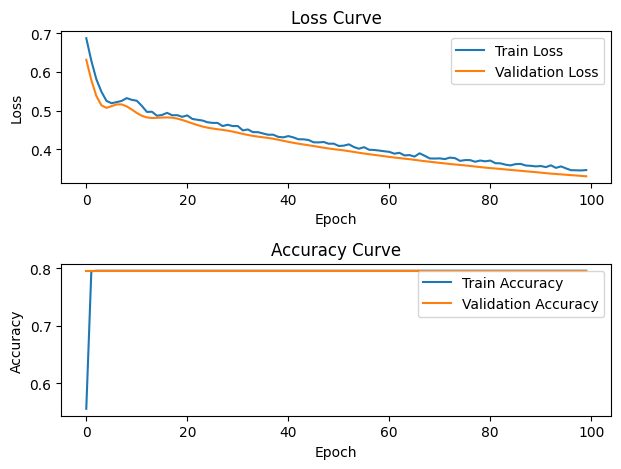

In [20]:
from torch_geometric.data import DataLoader

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

data = merged_graph

train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []
epoch_num = 101

def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out, data.y.long())  # Compute the loss for the training dataset.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.

    # Calculate training accuracy
    pred = out.argmax(dim=1)  # Use the class with the highest probability
    train_correct = pred == data.y.long()  # Compare predictions with true labels
    train_acc = int(train_correct.sum()) / len(data.y)  # Calculate accuracy

    train_loss_list.append(loss.item())  # Append training loss to the list
    train_acc_list.append(train_acc)    # Append training accuracy to the list
    return loss

def test():
    model.eval()
    with torch.no_grad():  # No gradients for evaluation
        out = model(data.x, data.edge_index)  # Forward pass
        loss = criterion(out, data.y.long())  # Compute evaluation loss

        # Calculate test accuracy
        pred = out.argmax(dim=1)  # Use the class with the highest probability
        test_correct = pred == data.y.long()  # Compare predictions with true labels
        test_acc = int(test_correct.sum()) / len(data.y)  # Calculate accuracy

    val_loss_list.append(loss.item())  # Append validation loss to the list
    val_acc_list.append(test_acc)     # Append validation accuracy to the list
    return test_acc

for epoch in range(1, epoch_num):
    loss = train()  # Pass the training dataset to train function.
    test_acc = test()  # Pass the test dataset to test function.
    #print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

# Plot learning curve
plt.subplot(2,1,1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.subplot(2,1,2)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7960
